### How long should people infected with the virus isolate for? Possible steps to answer this are:
- Find all terms that describe isolation (incubation, quarantine, isolation, infectious, transmissable, spreading, transferable, contagious)
- Look for all numbers used near these words (in the form 'XX days') that describe the recommend isolation period.
- Put all numbers into a list and average them to determine the recommended isolation period.
- Spot check a few examples to check it's working as expected.

In [1]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
stopwords=set(nltk.corpus.stopwords.words('english'))
from collections import defaultdict

### Import data and return english sentences

In [2]:
data = pd.read_csv("Data/clean_pmc.csv", nrows=10000)

In [3]:
data_cleaned = data[data['text'].apply(lambda x: bool(re.match('.*[a-zA-Z]+', x)))]
lang = pd.read_csv("Data/predicted_lang_10k.csv", index_col=0).squeeze()
data_eng = data_cleaned[lang == 'en']
# reset index for use in pd.iterrows()
data_eng = data_eng.reset_index()

### Define functions to determine recommended isolation period

In [4]:
def extract_days(tokenized_sent, anchor_word='days', days_regex="[0-9.]+"):
    
    # find index position of anchor word in sentence
    anchor_pos = tokenized_sent.index(anchor_word)
    days=[]

    # search for the two words preceding the anchor word and check
    # if they are numbers (using days_regex to confirm). If so, add
    # them to `days` list and take average. This is useful if a range
    # has been given. e.g. 2-6 days will return 4 days.
    for i in [anchor_pos-2, anchor_pos-1]:
        if i >= 0 and bool(re.match(days_regex, tokenized_sent[i])):
            day = re.findall(days_regex, tokenized_sent[i])
            days.extend(day)

    if days == []:
        return None
    else:
        try:
            np.asarray(days, dtype=np.float32).mean()
        except:
            print(f"Days list {days} can't be converted to numpy array. Extracted from {tokenized_sent}")
        else:
            return np.asarray(days, dtype=np.float32).mean()

In [5]:
def recommended_isolation(data, keywords, anchor_word='days', subset=None):

    # take subset of data to avoid long run time if requested by user
    if subset is not None:
        data = data[:subset]

    isolation=[]
    index=[]
    keyword_counter = defaultdict(int)
    
    # loop through pandas dataframe
    for indx, row in data.iterrows():
        # split 'text' column into sentences
        sents = sent_tokenize(row['text'])
        # split those sentences into words
        words = [word_tokenize(sent) for sent in sents]
        # loop through list of lists where outer list is each sentence and
        # inner list is each word in that sentence. Convert to lower text
        # and remove stopwords. Then extract the no. of days from each sentence
        # that contains a keyword(s).
        for sent in words:
            sent_clean = [word.lower() for word in sent if word.lower() not in stopwords]
            keywords_present = [word for word in keywords if word in sent_clean]
            if len(keywords_present) > 0 and anchor_word in sent_clean:
                days_from_sent = extract_days(sent_clean)
                if days_from_sent is not None:
                    isolation.append(days_from_sent)
                    index.append(indx)
                    for keyword_present in keywords_present:
                        keyword_counter[keyword_present] += 1
            
    return isolation, index, keyword_counter

### Run word2vec to determine keywords

In [17]:
import gensim
from gensim.models import Word2Vec
from tqdm import tqdm
tqdm.pandas()

C:\Users\charl\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [19]:
corpus=[]
for index, row in tqdm(data_eng.iterrows(), total=data_eng.shape[0]):
    words = word_tokenize(row['text'])
    words_cleaned = [word.lower() for word in words if word.lower() not in stopwords]
    corpus.append(words_cleaned)

100%|██████████| 6427/6427 [14:11<00:00,  7.55it/s] 


In [20]:
model = Word2Vec(sentences=corpus)

In [ ]:
model.save("Data/word2vec_embeddings.model")

In [21]:
model.wv.most_similar('quarantine')

[('quarantining', 0.7559069395065308),
 ('quarantined', 0.6932406425476074),
 ('containment', 0.6587002277374268),
 ('notification', 0.6581401228904724),
 ('precautionary', 0.6495118141174316),
 ('quarantines', 0.6484743356704712),
 ('precautions', 0.6436688303947449),
 ('compulsory', 0.6422392725944519),
 ('tracing', 0.6411328911781311),
 ('precaution', 0.6385451555252075)]

### Define keywords and run functions

In [12]:
keywords = ['quarantine', 'quarantining', 'quarantined', 'containment', 'notification', 'precautionary', 'quarantines', 'precautions', 'compulsory', 'tracing', 'precaution']
days_to_isolate = recommended_isolation(data_eng, keywords=keywords, subset=5000)

In [15]:
a = np.asarray(days_to_isolate[0], dtype=np.float32)
print(f'Median recommended isolation: {np.median(a)} days')
print(f'Number of keywords found: {len(days_to_isolate[0])}')

Median recommended isolation: 10.0 days
Number of keywords found: 85


### Error analysis

In [16]:
import matplotlib.pyplot as plt

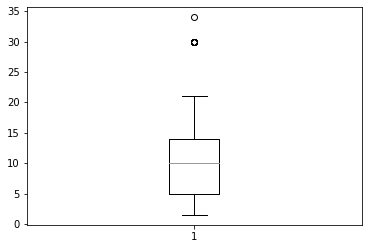

In [40]:
result = plt.boxplot(a)
plt.show()

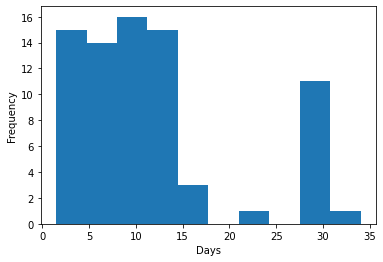

In [45]:
plt.hist(a[a < 35])
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()

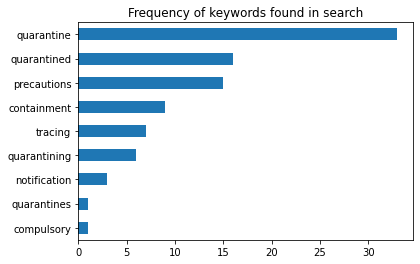

In [113]:
df = pd.DataFrame(days_to_isolate[2].items(), columns=['keyword', 'frequency'])
df = df.sort_values('frequency', ascending=True)
df.plot(x='keyword', y='frequency', kind='barh', legend=False)
plt.title('Frequency of keywords found in search')
plt.ylabel('')
plt.show()

In [115]:
print("Day", "Index", "\n---------")
for day, index in zip(days_to_isolate[0], days_to_isolate[1]):
    print(day, index)

In [114]:
print(data_eng.iloc[678, 6])